# <b> Data Science Capstone - The Best District in Inner London to Live in

Importing libraries

In [124]:
import pandas as pd
import numpy as np
import geocoder
import folium
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from geopy import distance
import sklearn.neighbors
import string
import requests

<b> 1. Introduction

1.1 Business Problem

You have been thinking for a long time about what it's like to live in England. Of all places, you specified inner London to be your preferred area. Probably because you're a big football fan and there are many teams in the city to follow. However, that's only the choice you've made so far and you're not sure which district is best suited to your needs and other specifications. Such can be proximity to necessities, whether or not the place is a hot spot for crimes, or maybe the general atmosphere of the area. Of course, there can be many specifications but, in this project, we consider only these factors to determine the ideal place for you. 

1.2 Audience

The target audience of this project would be any one who is looking into moving to Inner London and is actively seeking which area is most suitable for their needs.

<b> 2. Data

2.1. Location 

First, we need to have all postcodes in Inner London with their respective district names. We scrape Wikipedia for this. 

In [2]:
url='https://en.wikipedia.org/wiki/London_postal_district'
response=pd.read_html(url)
res=response[1]
df=pd.DataFrame()
res_1=res
res_1=res_1.drop([0,1,5,8],axis=0).reset_index(drop=True)
for let in res_1[0].unique():
    for dis in res_1[res_1[0]==let][1]:
        area=res[res[0]==let][res[res[0]==let][1]==dis][2].reset_index(drop=True)[0]
        zips=[]
        districts=[]
        #making a list of zip codes
        for j in range(0,50):
            code=let+str(j)+' '
            if area.find(code)!=-1:
                zips.append(code)  
        #making a list of districts
        for i in range(0,len(zips)):
            if i+1<len(zips):
                districts.append(area[area.find(zips[i]):area.find(zips[i+1])])
            else:
                districts.append(area[area.find(zips[i]):])
        for i in range(0,len(districts)):
            for j in zips:
                if districts[i].find('Head district')==-1:
                    districts[i]=districts[i].replace(j,'')
        for i in range(0,len(zips)):
            zips[i]=zips[i].replace(' ','')
        zips=pd.DataFrame(zips,columns=['Postcode'])
        districts=pd.DataFrame(districts,columns=['District'])
        df_area=pd.concat([zips,districts],axis=1)
        df=pd.concat([df,df_area],axis=0).reset_index(drop=True)
df

,Postcode,District
0,E1,E1 Head district
1,E2,Bethnal Green
2,E3,Bow
3,E4,Chingford
4,E5,Clapton
...,...,...
115,W12,Shepherds Bush
116,W13,West Ealing
117,W14,West Kensington
118,WC1,WC1 Head district


We use the Geocoder API to retrieve the respective geographical locations of these postcodes.

In [5]:
lats=[]
longs=[]
for i in df['Postcode']:
    lat_lng_coords=None
    while(lat_lng_coords is None):
        g=geocoder.arcgis('{}, London'.format(i))
        lat_lng_coords=g.latlng
    latitude=lat_lng_coords[0]
    longitude=lat_lng_coords[1]
    lats.append(latitude)
    longs.append(longitude)

df_lat=pd.DataFrame(lats,columns=['Latitude'])
df_long=pd.DataFrame(longs,columns=['Longitude'])
df_ll=pd.concat([df,df_lat,df_long],axis=1)
df_ll

,Postcode,District,Latitude,Longitude
0,E1,E1 Head district,51.52022,-0.05431
1,E2,Bethnal Green,51.52669,-0.06257
2,E3,Bow,51.52702,-0.02594
3,E4,Chingford,51.61780,-0.00934
4,E5,Clapton,51.55897,-0.05323
...,...,...,...,...
115,W12,Shepherds Bush,51.50645,-0.23691
116,W13,West Ealing,51.51453,-0.31951
117,W14,West Kensington,51.49568,-0.20993
118,WC1,WC1 Head district,51.52450,-0.12273


As stated in the introduction, we consider crime and venues as factors. Each of these has a required dataset.

2.2. Crime

Ideally, we want to live in a crime-free place. However, this is hard to come by in any place in the world, let alone the capital of England. Hence, we only choose districts with relatively low crime rates compared to the rest of the areas in the city. In this project, we choose to account for crimes in the last 2 years of available crime data. As of writing, the latest data in the UK crime stats website is crimes for November 2020, hence, we use the data from January 2019 to November 2020.

In [6]:
crimes_count=[]
for i in range(0,len(df_ll)):
    district=df_ll['Postcode'].iloc[i]
    url='https://www.ukcrimestats.com/Postcode_Districts/{}/'.format(district)
    response=pd.read_html(url)
    crimes=response[0]['Total'].iloc[0:23].sum()
    crimes_count.append(crimes)
    print("{} crimes counted in postcode {}".format(crimes,district))
crimes_count=pd.DataFrame(crimes_count,columns=['Crime Count'])
crimes_count.to_csv('crimes_count.csv',index=False)
df2=pd.concat([df_ll,crimes_count],axis=1)

33567 crimes counted in postcode E1
18982 crimes counted in postcode E2
19294 crimes counted in postcode E3
13461 crimes counted in postcode E4
13736 crimes counted in postcode E5
20208 crimes counted in postcode E6
11696 crimes counted in postcode E7
18746 crimes counted in postcode E8
12368 crimes counted in postcode E9
12028 crimes counted in postcode E10
12174 crimes counted in postcode E11
7947 crimes counted in postcode E12
11813 crimes counted in postcode E13
27232 crimes counted in postcode E14
20342 crimes counted in postcode E15
13841 crimes counted in postcode E16
26820 crimes counted in postcode E17
3218 crimes counted in postcode E18
3456 crimes counted in postcode E20
0 crimes counted in postcode EC1
0 crimes counted in postcode EC2
0 crimes counted in postcode EC3
0 crimes counted in postcode EC4
33161 crimes counted in postcode N1
3737 crimes counted in postcode N2
4375 crimes counted in postcode N3
17365 crimes counted in postcode N4
6578 crimes counted in postcode N5


After running the code above, we are still left with districts with zero crimes. This happened because for such districts, the website only provides data of their subdistricts. We retrieve these and sum them up to get the desired values.

In [12]:
crimes_count=[]
for i in df2[df2['Crime Count']==0]['Postcode']:
    crimes=0
    for j in list(string.ascii_uppercase):
        district=i+j
        url='https://www.ukcrimestats.com/Postcode_Districts/{}/'.format(district)
        response=pd.read_html(url)
        crimes+=response[0]['Total'].iloc[0:23].sum()
    crimes_count.append(crimes)
    print("{} crimes counted in postcode {}".format(crimes,i))
df2.loc[df2['Crime Count']==0,'Crime Count']=crimes_count

13970 crimes counted in postcode EC1
9199 crimes counted in postcode EC2
4294 crimes counted in postcode EC3
4304 crimes counted in postcode EC4
31142 crimes counted in postcode SW1
64420 crimes counted in postcode W1
18515 crimes counted in postcode WC1
25083 crimes counted in postcode WC2


Of course, number of crimes isn't enough for our analysis because more populous districts tend to have more crimes. Therefore, what we need to consider instead is the crime rate of each district. To get such values, we need to divide the number of crimes by the district's population. Crime rate is expressed as number of crimes per 100,000 persons. Hence, we put a multiplier of 100,000 to attain the crime rates. Population data is based on the 2011 census and can be gathered from https://postal-codes.cybo.com/

In [29]:
population=[]
for i in range(0,len(df2)):
    post=df2['Postcode'].iloc[i]
    url='https://postal-codes.cybo.com/united-kingdom/{}/'.format(post)
    response=pd.read_html(url)
    try:
        pop=int(response[5]['Population'].iloc[0])
        print('Population of {} is {}'.format(post,pop))
    except:
        print('No Data Available for {}'.format(post))
        pop=0
    population.append(pop)
population=pd.DataFrame(population,columns=['Population'])
df2=pd.concat([df2,population['Population']],axis=1)

Population of E1 is 71450
Population of E2 is 49223
Population of E3 is 58412
Population of E4 is 63468
Population of E5 is 50762
Population of E6 is 87076
Population of E7 is 59885
Population of E8 is 43436
Population of E9 is 42850
Population of E10 is 45733
Population of E11 is 58374
Population of E12 is 46139
Population of E13 is 49158
Population of E14 is 82345
Population of E15 is 58308
Population of E16 is 48754
Population of E17 is 110756
Population of E18 is 20065
No Data Available for E20
No Data Available for EC1
No Data Available for EC2
No Data Available for EC3
No Data Available for EC4
Population of N1 is 92515
Population of N2 is 24905
Population of N3 is 27857
Population of N4 is 52343
Population of N5 is 22286
Population of N6 is 21603
Population of N7 is 52208
Population of N8 is 42803
Population of N9 is 55723
Population of N10 is 28425
Population of N11 is 30412
Population of N12 is 30074
Population of N13 is 32685
Population of N14 is 31505
Population of N15 is 46

Similar to crime data, some districts only have data available for their subdistricts. 

In [20]:
population=[]
for i in df2[df2['Population']==0]['Postcode']:
    pops=0
    for j in list(string.ascii_uppercase):
        post=i+j
        url='https://postal-codes.cybo.com/united-kingdom/{}/'.format(post)
        try:
            response=pd.read_html(url)
            pops+=int(response[5]['Population'].iloc[0])
        except:
            pops+=0
    population.append(pops)
    print('Population of {} is {}'.format(i,pops))
missing_pop=pd.DataFrame(population,columns=['Population'])
df2.loc[df2['Population']==0,'Population']=population
df2

Population of E20 is 0
Population of EC1 is 42435
Population of EC2 is 11210
Population of EC3 is 5617
Population of EC4 is 5366
Population of SW1 is 54818
Population of W1 is 56613
Population of WC1 is 34114
Population of WC2 is 9503


,Postcode,District,Latitude,Longitude,Crime Count,Population
0,E1,E1 Head district,51.52022,-0.05431,33567,71450
1,E2,Bethnal Green,51.52669,-0.06257,18982,49223
2,E3,Bow,51.52702,-0.02594,19294,58412
3,E4,Chingford,51.61780,-0.00934,13461,63468
4,E5,Clapton,51.55897,-0.05323,13736,50762
...,...,...,...,...,...,...
115,W12,Shepherds Bush,51.50645,-0.23691,17494,51698
116,W13,West Ealing,51.51453,-0.31951,7147,32864
117,W14,West Kensington,51.49568,-0.20993,7941,34338
118,WC1,WC1 Head district,51.52450,-0.12273,18515,34114


In [35]:
df2

,Postcode,District,Latitude,Longitude,Crime Count,Population
0,E1,E1 Head district,51.52022,-0.05431,33567,71450
1,E2,Bethnal Green,51.52669,-0.06257,18982,49223
2,E3,Bow,51.52702,-0.02594,19294,58412
3,E4,Chingford,51.61780,-0.00934,13461,63468
4,E5,Clapton,51.55897,-0.05323,13736,50762
...,...,...,...,...,...,...
115,W12,Shepherds Bush,51.50645,-0.23691,17494,51698
116,W13,West Ealing,51.51453,-0.31951,7147,32864
117,W14,West Kensington,51.49568,-0.20993,7941,34338
118,WC1,WC1 Head district,51.52450,-0.12273,18515,34114


Population of E20 is not available from the postal-codes.cybo website so we put this manually. According to http://www.eastvillagelondon.co.uk/, the population of E20 is about 6,000 people.

In [36]:
population=6000
df2.loc[df2['Population']==0,'Population']=population
df2

,Postcode,District,Latitude,Longitude,Crime Count,Population
0,E1,E1 Head district,51.52022,-0.05431,33567,71450
1,E2,Bethnal Green,51.52669,-0.06257,18982,49223
2,E3,Bow,51.52702,-0.02594,19294,58412
3,E4,Chingford,51.61780,-0.00934,13461,63468
4,E5,Clapton,51.55897,-0.05323,13736,50762
...,...,...,...,...,...,...
115,W12,Shepherds Bush,51.50645,-0.23691,17494,51698
116,W13,West Ealing,51.51453,-0.31951,7147,32864
117,W14,West Kensington,51.49568,-0.20993,7941,34338
118,WC1,WC1 Head district,51.52450,-0.12273,18515,34114


The code below calculates the crime rates.

In [38]:
crime_rate=[]
for i in range(0,len(df2)):
    crime_rate.append((df2['Crime Count'].iloc[i]/df2['Population'].iloc[i])*100000)
crime_rate=pd.DataFrame(crime_rate,columns=['Crime Rate'])
df3=pd.concat([df2,crime_rate],axis=1)

Below is our transformed crime and locations dataset

In [39]:
df3

,Postcode,District,Latitude,Longitude,Crime Count,Population,Crime Rate
0,E1,E1 Head district,51.52022,-0.05431,33567,71450,46979.706088
1,E2,Bethnal Green,51.52669,-0.06257,18982,49223,38563.273267
2,E3,Bow,51.52702,-0.02594,19294,58412,33030.884065
3,E4,Chingford,51.61780,-0.00934,13461,63468,21209.113254
4,E5,Clapton,51.55897,-0.05323,13736,50762,27059.611520
...,...,...,...,...,...,...,...
115,W12,Shepherds Bush,51.50645,-0.23691,17494,51698,33838.833224
116,W13,West Ealing,51.51453,-0.31951,7147,32864,21747.200584
117,W14,West Kensington,51.49568,-0.20993,7941,34338,23125.982876
118,WC1,WC1 Head district,51.52450,-0.12273,18515,34114,54273.905142


2.3 Venues

One of the factors in choosing a site for a house is convenience. Is there a supermarket? Is there a train station nearby? How about a pharmacy in case you need an emergency medicine? Moreover, personal taste comes into play. What would be the ideal atmosphere of the place you live in? Do you want to live in a hotspot for coffee shops, restaurants, bars, or recreation? All of these questions can be answered by venue data we can attain from Foursquare API. This will be done later once we've analysed the crime data and have filtered down viable districts.

<b> 3. Methodology

3.1 Overview

We will follow the following steps in performing our analysis:
1. We perform k-means clustering to cluster districts according to their crime rate. In order to determine the optimal number of clusters, we utilize the Elbow method.

    Elbow Method for Clustering
    
    In clustering, it is ideal that we minimize WCSS (within cluster sum of squares) and increasing the number of clusters provides exactly that. However, we need a balance between this and having observable distinction between the clusters we create. The elbow method is one of the most popular methods to determine the optimal number of clusters. This is performed by performing k-means clustering multiple times, each using a different number of clusters and then plotting the resulting WCSS as a function of number of clusters. In this project, we perform clustering for 1 up to 10 clusters and, to determine the optimal number of clusters, we pick the number where the 'elbow' of the graph is observed. In other words, we choose the number of clusters such that adding another cluster doesn't give much better modeling of the data (diminishing returns).


2. After obtaining our final crime rate clusters, we narrow down our districts by removing clusters that exhibit high crime rates.


3. We utilize Foursquare API to explore venue categories around our narrowed down districts. 


4. We define a set of venue categories that we consider important and evaluate the districts against this set. We further narrow down the districts by removing ones that score low on this metric.


5. This narrowed down set becomes our final selection of districts to live in. We perform a final clustering of venue categories to get an idea of the general atmosphere of these places. The final choice according to this clustering is made after.

3.2 Crime Analysis

Let's take a look again at our crime rate dataset.

In [105]:
df3

,Postcode,District,Latitude,Longitude,Crime Count,Population,Crime Rate
0,E1,E1 Head district,51.52022,-0.05431,33567,71450,46979.706088
1,E2,Bethnal Green,51.52669,-0.06257,18982,49223,38563.273267
2,E3,Bow,51.52702,-0.02594,19294,58412,33030.884065
3,E4,Chingford,51.61780,-0.00934,13461,63468,21209.113254
4,E5,Clapton,51.55897,-0.05323,13736,50762,27059.611520
...,...,...,...,...,...,...,...
115,W12,Shepherds Bush,51.50645,-0.23691,17494,51698,33838.833224
116,W13,West Ealing,51.51453,-0.31951,7147,32864,21747.200584
117,W14,West Kensington,51.49568,-0.20993,7941,34338,23125.982876
118,WC1,WC1 Head district,51.52450,-0.12273,18515,34114,54273.905142


As explained in the previous section, we will cluster districts according to their crime rate in order for us to narrow down our selection to only those that have low crime rates. To do that, we need to determine first the optimal number of clusters through the elbow method. 

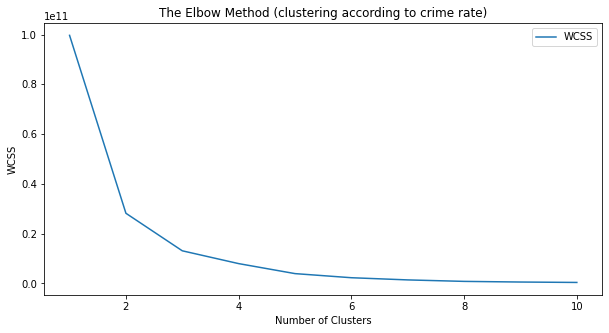

In [106]:
#Elbow method
wcss=[]
X=np.array(df3.loc[:,'Crime Rate']).reshape(-1,1)
for i in range(1,11):
    kmeans=KMeans(n_clusters=i,init='k-means++',random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
wcss=pd.DataFrame(wcss,columns=['WCSS'],index=range(1,11))
wcss.plot(kind='line',figsize=(10,5))
plt.title('The Elbow Method (clustering according to crime rate)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

Based on the graph above, the elbow is on 3 clusters and, hence, we will be choosing that as the optimal number of clusters for our crime rate dataset. Let's now apply this to our dataset. Moreover, we also need to make sure that our cluster labels are ordered in terms the means of each cluster.

In [107]:
n_clusters=3
kmeans=KMeans(n_clusters=n_clusters,init='k-means++',random_state=0)
kmeans.fit(X)
crime_clusters=kmeans.labels_
df3_crime_clustered=pd.concat([pd.DataFrame(crime_clusters,columns=['Crime Cluster']),df3],axis=1)
means=[]
for i in range(0,n_clusters):
    mean=int(df3_crime_clustered[df3_crime_clustered['Crime Cluster']==i]['Crime Rate'].mean())
    means.append(mean)
means=pd.DataFrame(means,columns=['Cluster mean']).reset_index()
means=means.rename(columns={'index':'Cluster Label'})
means=means.sort_values(by=['Cluster mean'],ascending=True).reset_index(drop=True)
new_clusters=pd.DataFrame(list(range(1,n_clusters+1)),columns=['New Cluster Label'])
means=pd.concat([means,new_clusters],axis=1)
new_clusters=[]
for i in range(0,len(df3_crime_clustered)):
    old=df3_crime_clustered['Crime Cluster'].iloc[i]
    new=means[means['Cluster Label']==old]['New Cluster Label'].reset_index(drop=True)[0]
    new_clusters.append(new)
new_clusters=pd.DataFrame(new_clusters,columns=['Cluster (crime)'])
df3_crime_clustered=pd.concat([new_clusters,df3_crime_clustered],axis=1)
df3_crime_clustered=df3_crime_clustered.drop(columns=['Crime Cluster'])
df3_crime_clustered

,Cluster (crime),Postcode,District,Latitude,Longitude,Crime Count,Population,Crime Rate
0,2,E1,E1 Head district,51.52022,-0.05431,33567,71450,46979.706088
1,1,E2,Bethnal Green,51.52669,-0.06257,18982,49223,38563.273267
2,1,E3,Bow,51.52702,-0.02594,19294,58412,33030.884065
3,1,E4,Chingford,51.61780,-0.00934,13461,63468,21209.113254
4,1,E5,Clapton,51.55897,-0.05323,13736,50762,27059.611520
...,...,...,...,...,...,...,...,...
115,1,W12,Shepherds Bush,51.50645,-0.23691,17494,51698,33838.833224
116,1,W13,West Ealing,51.51453,-0.31951,7147,32864,21747.200584
117,1,W14,West Kensington,51.49568,-0.20993,7941,34338,23125.982876
118,2,WC1,WC1 Head district,51.52450,-0.12273,18515,34114,54273.905142


Let's now take a look at the summary and visualization of our clusters.

In [108]:
#Cluster summary
for i in range(0,n_clusters):
    cluster=means['New Cluster Label'][i]
    cluster_size=len(df3_crime_clustered[df3_crime_clustered['Cluster (crime)']==cluster])
    cluster_mean=means[means['New Cluster Label']==cluster]['Cluster mean'][i]
    print('Cluster {} has {} district/s and has a mean of {} crimes per 100,000 people'.format(cluster,cluster_size,cluster_mean))

Cluster 1 has 108 district/s and has a mean of 24990 crimes per 100,000 people
Cluster 2 has 10 district/s and has a mean of 65585 crimes per 100,000 people
Cluster 3 has 2 district/s and has a mean of 219114 crimes per 100,000 people


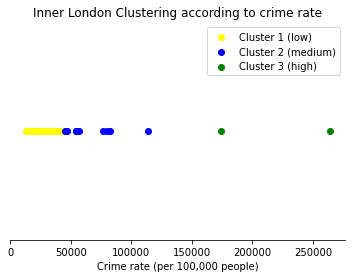

In [111]:
plt.scatter(df3_crime_clustered[df3_crime_clustered['Cluster (crime)']==1]['Crime Rate'],pd.DataFrame(np.zeros((len(df3_crime_clustered[df3_crime_clustered['Cluster (crime)']==1]),1))),color='yellow')
plt.scatter(df3_crime_clustered[df3_crime_clustered['Cluster (crime)']==2]['Crime Rate'],pd.DataFrame(np.zeros((len(df3_crime_clustered[df3_crime_clustered['Cluster (crime)']==2]),1))),color='blue')
plt.scatter(df3_crime_clustered[df3_crime_clustered['Cluster (crime)']==3]['Crime Rate'],pd.DataFrame(np.zeros((len(df3_crime_clustered[df3_crime_clustered['Cluster (crime)']==3]),1))),color='green')
for i in ['right','top','left']:
    plt.gca().spines[i].set_visible(False)
plt.title('Inner London Clustering according to crime rate')
plt.tick_params(axis='y',which='both',labelleft=False,left=False)
plt.legend(['Cluster 1 (low)','Cluster 2 (medium)','Cluster 3 (high)'])
plt.xlabel('Crime rate (per 100,000 people)')
plt.show()

Let's also examine if geographical locations of districts affect crime rates through a choropleth map.

In [144]:
#Crime map
london_lat=51.5074
london_long=-0.1278
geoj=r'london_postcodes.geojson'
map_london_crime=folium.Map(location=[london_lat,london_long],zoom_start=11)
map_london_crime.choropleth(
    geo_data=geoj,
    data=df3_crime_clustered,
    columns=['Postcode','Cluster (crime)'],
    key_on='feature.properties.Name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=1,
    legend_name='Crime clusters in Inner London'
)
for lat,lng,label,clus,post in zip(df_ll['Latitude'],df_ll['Longitude'],df_ll['District'],df3_crime_clustered['Cluster (crime)'],df3_crime_clustered['Postcode']):
    label=folium.Popup(str(post)+', '+str(label)+' - Cluster '+str(clus),parse_html=True)
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london_crime)
map_london_crime

It seems that almost all districts in Inner London are relatively at the same level with only 12 districts (clusters 2 and 3) qualifying to be riskier than the rest. We are now able to narrow down our selection to just the first cluster. Moreover, it can be observed from the choropleth map that the riskier districts tend to be at the center of the city. We prevent these places as these are not ideal for residence.

In [122]:
df3_filtered=df3_crime_clustered[df3_crime_clustered['Cluster (crime)']<=1].reset_index(drop=True)

3.3 Venue Analysis

To start with this section, let's perform an explore query to Foursquare on venue categories that are within 500 meters from the center of our filtered districts. 

In [126]:
#Searching venues
RADIUS=500
CLIENT_ID='MSOG3Y4IVKOYHIACJTPVUGCPTKDMCZNA4XH1315QT0HGFSVP'
CLIENT_SECRET='P2LYJ3XZDP04J2TN23VUFLPHGBVI4XLU0IP3EVEN3YOCX1YL'
VERSION='20180605'
LIMIT=100
def getNearbyVenues(names,latitudes,longitudes,radius=500):
    venues_list=[]
    super_counter=0
    for name,lat,lng in zip(names,latitudes,longitudes):
        
        # venue counter for each neighborhood
        counter=0
        
        # create the API request URL
        url='https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(CLIENT_ID,CLIENT_SECRET,VERSION,lat,lng,radius,LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        for v in results:
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name'])])
            counter+=1
        print('{} venues found near {}'.format(counter,name))
        super_counter+=counter
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print('{} total venues found.'.format(super_counter))
    return(nearby_venues)
london_venues=getNearbyVenues(names=df3_filtered['District'],latitudes=df3_filtered['Latitude'],longitudes=df3_filtered['Longitude'])
cats=pd.DataFrame(london_venues['Venue Category'].unique(),columns=['Categories'])

36 venues found near Bethnal Green 
11 venues found near Bow 
6 venues found near Chingford 
18 venues found near Clapton 
18 venues found near East Ham
16 venues found near Forest Gate 
59 venues found near Hackney 
22 venues found near Homerton 
38 venues found near Leyton 
29 venues found near Leytonstone
5 venues found near Manor Park 
7 venues found near Plaistow 
10 venues found near Poplar 
55 venues found near Stratford 
24 venues found near Victoria Docks and North Woolwich 
51 venues found near Walthamstow 
6 venues found near Woodford and South Woodford 
82 venues found near EC1 Head district
51 venues found near N1 Head district 
32 venues found near East Finchley 
31 venues found near Finchley 
28 venues found near Finsbury Park 
19 venues found near Highbury 
23 venues found near Highgate 
36 venues found near Holloway
49 venues found near Hornsey 
9 venues found near Lower Edmonton 
44 venues found near Muswell Hill 
8 venues found near New Southgate 
34 venues found nea

There are 3268 total venues found near our districts. Let's have a quick look at the query result.

In [127]:
london_venues

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bethnal Green,51.52669,-0.06257,The King's Arms,51.525754,-0.065868,Pub
1,Bethnal Green,51.52669,-0.06257,Sam's Cafe,51.526424,-0.065056,Café
2,Bethnal Green,51.52669,-0.06257,E Pellicci,51.526516,-0.063426,Café
3,Bethnal Green,51.52669,-0.06257,Double Impresso Coffee,51.526647,-0.064002,Coffee Shop
4,Bethnal Green,51.52669,-0.06257,Cafe 338,51.526582,-0.063258,Café
...,...,...,...,...,...,...,...
3263,West Kensington,51.49568,-0.20993,Tesco Express,51.495106,-0.211045,Grocery Store
3264,West Kensington,51.49568,-0.20993,Costa Coffee,51.496415,-0.206538,Coffee Shop
3265,West Kensington,51.49568,-0.20993,Frank's Sandwich Bar,51.495926,-0.207845,Sandwich Place
3266,West Kensington,51.49568,-0.20993,Shandeez,51.497566,-0.211850,Middle Eastern Restaurant


We are interested in the 'Venue Category' column as this allows us to gauge the kind of venues we can see near the districts. The next step is now to look at the different venue categories found and determine which ones we prefer to live near to. Let's say you are a married man about to start a family and you commute your way to work in the city center. Venue categories you'd ideally live near to are the supermarket, pharmacy, daycare, train station, bus stop, school, and church. Of course, all of these can be changed according to the person doing the analysis. We want to make sure that you live in districts with many of these venues nearby so we'll score each district depending on how many of these venues are present near them.

In [142]:
venue_priority=['Supermarket','Pharmacy','Daycare','Train Station','School','Church','Bus Stop']
prio_score=[]
for i in range(0,len(df3_filtered)):
    score=0
    district=df3_filtered['District'].iloc[i]
    for j in london_venues[london_venues['Neighbourhood']==district]['Venue Category'].unique():
        for k in venue_priority:
            score_curr=0
            if j==k:
                score+=1
    prio_score.append(score)
prio_score=pd.DataFrame(prio_score,columns=['Venue Score'])
df_scored=pd.concat([prio_score,df3_filtered],axis=1)
for i in range(0,len(df_scored['Venue Score'].unique())):
    score=i
    count=len(df_scored[df_scored['Venue Score']==i])
    if score==0:
        print('There are {} districts with none of your preferred venues nearby'.format(count,score))
    else:
        print('There are {} districts with {} of your preferred venues nearby'.format(count,score))

There are 25 districts with none of your preferred venues nearby
There are 42 districts with 1 of your preferred venues nearby
There are 24 districts with 2 of your preferred venues nearby
There are 14 districts with 3 of your preferred venues nearby
There are 3 districts with 4 of your preferred venues nearby


We'll now narrow down our district selection to those with at least three of our preferred venues nearby.

In [143]:
df_score_filtered=df_scored[df_scored['Venue Score']>=3]
df_score_filtered.head(n=17)

,Venue Score,Cluster (crime),Postcode,District,Latitude,Longitude,Crime Count,Population,Crime Rate
8,3,1,E10,Leyton,51.55885,-0.00733,12028,45733,26300.483240
13,4,1,E15,Stratford,51.54014,0.00278,20342,58308,34887.150991
15,3,1,E17,Walthamstow,51.58477,-0.01943,26820,110756,24215.392394
20,3,1,N3,Finchley,51.60104,-0.19401,4375,27857,15705.208745
24,3,1,N7,Holloway,51.55457,-0.11478,14896,52208,28532.025743
30,3,1,N13,Palmers Green,51.62003,-0.10660,6929,32685,21199.326908
31,3,1,N14,Southgate,51.63429,-0.13366,5507,31505,17479.765117
44,3,1,NW6,Kilburn,51.54187,-0.19795,16634,66436,25037.630200
45,3,1,NW7,Mill Hill,51.61568,-0.24511,5039,28374,17759.216184
60,3,1,SE13,Lewisham,51.46196,-0.00754,14227,39452,36061.543141


We are now down to 17 districts! Based on our criteria so far, any of these is suitable for our needs (low crime rate and with many necessities nearby). The last step is now to perform another clustering to determine the general atmosphere of the areas according to the venues near them. Then we can choose to narrow down further according to which cluster we prefer. Before we do that, let's preprocess the our venues data.

In [148]:
#Onehot encoding and taking district means of frequencies
london_onehot=pd.get_dummies(london_venues['Venue Category'],prefix='',prefix_sep='')
london_onehot=pd.concat([london_venues['Neighbourhood'],london_onehot],axis=1)
london_grouped=london_onehot.groupby(['Neighbourhood']).mean().reset_index().reset_index(drop=True)

#Filtering score-filtered districts
neigh_mask=[]
for i in range(0,len(london_grouped)):
    neigh_mask.append(london_grouped['Neighbourhood'].iloc[i] in list(df_score_filtered['District']))
london_grouped=london_grouped[neigh_mask].reset_index(drop=True)
print('\n Onehot encoded mean frequencies of venues')
london_grouped.head(n=17)


 Onehot encoded mean frequencies of venues


,Neighbourhood,Adult Boutique,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,...,Video Game Store,Vietnamese Restaurant,Warehouse Store,Windmill,Wine Bar,Wine Shop,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio
0,Clapham,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.012987,0.012987,0.000000,0.000000,0.0,0.012987
1,Ealing,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.011494,0.022989,0.000000,0.0,0.011494,0.000000,0.000000,0.000000,0.0,0.000000
2,Finchley,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.032258,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3,Hanwell,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
4,Holloway,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.027778,0.000000,0.0,0.000000,0.000000,0.000000,0.027778,0.0,0.027778
5,Kilburn,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.028571,0.0,0.000000,0.000000,0.028571,0.000000,0.0,0.000000
6,Lewisham,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.023256,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
7,Leyton,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
8,Mill Hill,0.0,0.0,0.0,0.0,0.0,0.052632,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
9,Palmers Green,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


Let's now look at the most common venues per district.

In [150]:
def return_most_common_venues(row,num_top_venues):
    row_categories=row.iloc[1:]
    row_categories_sorted=row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues=10

indicators=['st','nd','rd']

# create columns according to number of top venues
columns=['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1,indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted=pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood']=london_grouped['Neighbourhood']

for ind in np.arange(london_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind,1:]=return_most_common_venues(london_grouped.iloc[ind,:],num_top_venues)

posts=[]
for i in range(0,len(neighborhoods_venues_sorted)):
    neigh=neighborhoods_venues_sorted['Neighbourhood'].iloc[i]
    post=df_score_filtered[df_score_filtered['District']==neigh]['Postcode'].reset_index(drop=True)[0]
    posts.append(post)
posts=pd.DataFrame(posts,columns=['Postcode'])
neighborhoods_venues_sorted=pd.concat([posts,neighborhoods_venues_sorted],axis=1)
neighborhoods_venues_sorted.head(n=17)

,Postcode,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,SW4,Clapham,Pub,Café,Burger Joint,Gym / Fitness Center,Grocery Store,Bus Stop,Turkish Restaurant,Gastropub,Tapas Restaurant,Bar
1,W5,Ealing,Coffee Shop,Pub,Platform,Clothing Store,Burger Joint,Bakery,Italian Restaurant,Grocery Store,Thai Restaurant,Bus Stop
2,N3,Finchley,Supermarket,Turkish Restaurant,Pizza Place,Japanese Restaurant,Pub,Café,Indian Restaurant,Park,Coffee Shop,Seafood Restaurant
3,W7,Hanwell,Pub,Café,Coffee Shop,Fish & Chips Shop,Bar,Bus Stop,Gym,Train Station,Supermarket,Convenience Store
4,N7,Holloway,Pub,Café,Pharmacy,Gym / Fitness Center,Supermarket,Coffee Shop,Soccer Stadium,Sushi Restaurant,Bistro,Bus Stop
5,NW6,Kilburn,Indian Restaurant,Pub,Supermarket,Brazilian Restaurant,Fast Food Restaurant,Portuguese Restaurant,Grocery Store,Gastropub,Sandwich Place,Entertainment Service
6,SE13,Lewisham,Coffee Shop,Clothing Store,Fast Food Restaurant,Pharmacy,Pub,Restaurant,Café,Hotel,Street Food Gathering,Market
7,E10,Leyton,Pub,Platform,Fast Food Restaurant,Clothing Store,Fried Chicken Joint,Grocery Store,Coffee Shop,Gym / Fitness Center,Pharmacy,Bus Stop
8,NW7,Mill Hill,Platform,Bus Stop,Juice Bar,Grocery Store,Stationery Store,Restaurant,Café,Train Station,Pharmacy,Coffee Shop
9,N13,Palmers Green,Sandwich Place,Bakery,Pub,Grocery Store,Pizza Place,Supermarket,Coffee Shop,Bookstore,Tea Room,Mediterranean Restaurant


We are now ready to perform venue category clustering. The elbow method is not useful this time around because the resulting graph of WCSS emulated an almost linear relationship with number of clusters. See below.

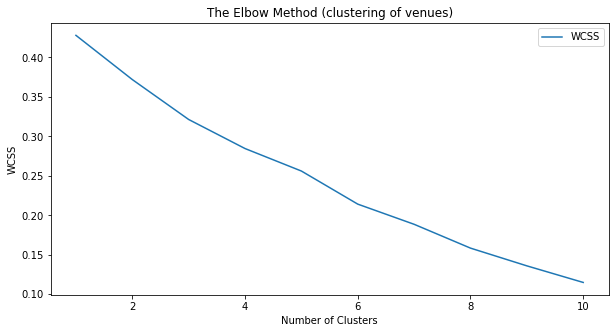

In [251]:
#Elbow method
wcss=[]
X=london_grouped.drop(columns=['Neighbourhood'])
for i in range(1,11):
    kmeans=KMeans(n_clusters=i,init='k-means++',random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
wcss=pd.DataFrame(wcss,columns=['WCSS'],index=range(1,11))
wcss.plot(kind='line',figsize=(10,5))
plt.title('The Elbow Method (clustering of venues)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

For our purposes, we'll use 4 clusters to see if we can properly cluster the districts.

In [252]:
n_clusters=4
kmeans=KMeans(n_clusters=n_clusters,random_state=0)
kmeans.fit(london_grouped.drop(columns=['Neighbourhood']))
df_clustered=pd.concat([pd.DataFrame(kmeans.labels_,columns=['Cluster (venue)']),neighborhoods_venues_sorted],axis=1)
#show cluster_values
values=np.zeros(df_clustered.drop(columns=['Cluster (venue)','Neighbourhood','Postcode']).shape)
a=0
for i in df_clustered['Neighbourhood']:
    b=0
    for j in df_clustered[df_clustered['Neighbourhood']==i].drop(columns=['Cluster (venue)','Neighbourhood','Postcode']).values[0]:
        values[a,b]=london_grouped[london_grouped['Neighbourhood']==i][j]
        b+=1
    a+=1
col=[]
for ind in np.arange(num_top_venues):
    try:
        col.append('{}{} Most Common Venue'.format(ind+1,indicators[ind]))
    except:
        col.append('{}th Most Common Venue'.format(ind+1))
values=pd.DataFrame(values,columns=col)
df_clustered_values=values=pd.concat([df_clustered[['Cluster (venue)','Neighbourhood']],values],axis=1)

Let's now observe the individual clusters and check for common traits between them.

In [253]:
i=0
print('\n Cluster {}'.format(i))
df_clustered[df_clustered['Cluster (venue)']==i]


 Cluster 0


,Cluster (venue),Postcode,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,0,N3,Finchley,Supermarket,Turkish Restaurant,Pizza Place,Japanese Restaurant,Pub,Café,Indian Restaurant,Park,Coffee Shop,Seafood Restaurant
12,0,N14,Southgate,Gym / Fitness Center,Ice Cream Shop,Pizza Place,Coffee Shop,Fast Food Restaurant,Pub,Portuguese Restaurant,Dessert Shop,Pharmacy,Sandwich Place


In [254]:
i=1
print('\n Cluster {}'.format(i))
df_clustered[df_clustered['Cluster (venue)']==i]


 Cluster 1


,Cluster (venue),Postcode,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,1,E10,Leyton,Pub,Platform,Fast Food Restaurant,Clothing Store,Fried Chicken Joint,Grocery Store,Coffee Shop,Gym / Fitness Center,Pharmacy,Bus Stop
8,1,NW7,Mill Hill,Platform,Bus Stop,Juice Bar,Grocery Store,Stationery Store,Restaurant,Café,Train Station,Pharmacy,Coffee Shop
11,1,SE16,Rotherhithe,Clothing Store,Café,Sporting Goods Shop,Bar,Bus Stop,Park,Pizza Place,Platform,Pharmacy,Movie Theater


In [255]:
i=2
print('\n Cluster {}'.format(i))
df_clustered[df_clustered['Cluster (venue)']==i]


 Cluster 2


,Cluster (venue),Postcode,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,2,SW4,Clapham,Pub,Café,Burger Joint,Gym / Fitness Center,Grocery Store,Bus Stop,Turkish Restaurant,Gastropub,Tapas Restaurant,Bar
1,2,W5,Ealing,Coffee Shop,Pub,Platform,Clothing Store,Burger Joint,Bakery,Italian Restaurant,Grocery Store,Thai Restaurant,Bus Stop
4,2,N7,Holloway,Pub,Café,Pharmacy,Gym / Fitness Center,Supermarket,Coffee Shop,Soccer Stadium,Sushi Restaurant,Bistro,Bus Stop
5,2,NW6,Kilburn,Indian Restaurant,Pub,Supermarket,Brazilian Restaurant,Fast Food Restaurant,Portuguese Restaurant,Grocery Store,Gastropub,Sandwich Place,Entertainment Service
6,2,SE13,Lewisham,Coffee Shop,Clothing Store,Fast Food Restaurant,Pharmacy,Pub,Restaurant,Café,Hotel,Street Food Gathering,Market
9,2,N13,Palmers Green,Sandwich Place,Bakery,Pub,Grocery Store,Pizza Place,Supermarket,Coffee Shop,Bookstore,Tea Room,Mediterranean Restaurant
10,2,SE15,Peckham,Grocery Store,Italian Restaurant,Pub,Bus Stop,Brewery,Bar,Fast Food Restaurant,Cocktail Bar,Supermarket,Coffee Shop
13,2,E15,Stratford,Pub,Platform,Sandwich Place,Fast Food Restaurant,Hotel,Coffee Shop,Bus Stop,General Entertainment,Café,Supermarket
14,2,SW17,Tooting,Pub,Indian Restaurant,Supermarket,Coffee Shop,Bar,Burger Joint,South Indian Restaurant,Fish & Chips Shop,Clothing Store,Pharmacy
15,2,E17,Walthamstow,Coffee Shop,Sandwich Place,Café,Pub,Bakery,Bookstore,Clothing Store,Pharmacy,Supermarket,Tea Room


In [256]:
i=3
print('\n Cluster {}'.format(i))
df_clustered[df_clustered['Cluster (venue)']==i]


 Cluster 3


,Cluster (venue),Postcode,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,3,W7,Hanwell,Pub,Café,Coffee Shop,Fish & Chips Shop,Bar,Bus Stop,Gym,Train Station,Supermarket,Convenience Store


<b> 4. Results and Discussion

We have analysed crime rates as well as venues across the 120 postcodes in Inner London trying to find the most ideal districts to live in. After certain decisions concerning them, we have narrowed them down to 17 districts and we have the following insights regarding our data:

1. Olymic Park, Bishopsgate, Fenchurch Street, Fleet Street, Greenwich, Strand, as well as the head districts of E1, NW1, SE1, SW1, W1, and WC1 are riskier to live in compared to the rest as they can be considered to be hotbeds for crime. We have also seen that these hotbeds tend to be at the center of the city.


2. Of the remaining districts, we selected our 17 districts Leyton, Stratford, Walthamstow, Finchley, Holloway, Palmers Green, Southgate, Kilburn, Mill Hill, Lewisham, Peckham, Rotherhithe, West Norwood, Clapham, Tooting, Ealing, and Hanwell because they have 3 or more of our preferred venues near them.

Of these 17 districts, we see the following distinctions (based on clustering) between them:

1. Finchley and Southgate are hotspots for restaurants with variety of cuisines such as Turkish, Italian, Japanese, Indian, and Portuguese. 


2. Hanwell boasts 2 coffee shops and 2 cafés but is a pretty quiet place as it doesn't have much other venues around it.


3. Leyton, Mill Hill, and Rotherhithe boast in transportation facilities such as platforms and bus stops.


4. Clapham, Ealing, Holloway, Kilburn, Lewisham, Palmers Green, Peckham, Stratford, Tooting, Walthamstow, and West Norwood are hotpots for pubs.

The final choice would be depending on one's preference regarding the atmosphere around the are as described by the above four points. 



<b> 5. Conclusion

We have now performed a full data science project using Python and its libraries for web scraping, visualization, dataset manipulation, and machine learning. It is important to note, however, that most of the decisions made throughout the process was based on personal preference and can be changed according to one's own, yielding different results. Moreover, more techniques, factors, and datasets can be utilized other than the ones performed in this project.